Name: Vishal Vijay Devadiga

Roll Number: CS21BTECH11061

# Tutorial – cross-frequency coupling


In [8]:
# Imports

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert
from scipy.fftpack import fft, fftfreq
from scipy.integrate import solve_ivp

# Question: 
Generate relevant signals using random white noise and sinusoid/cosine bases

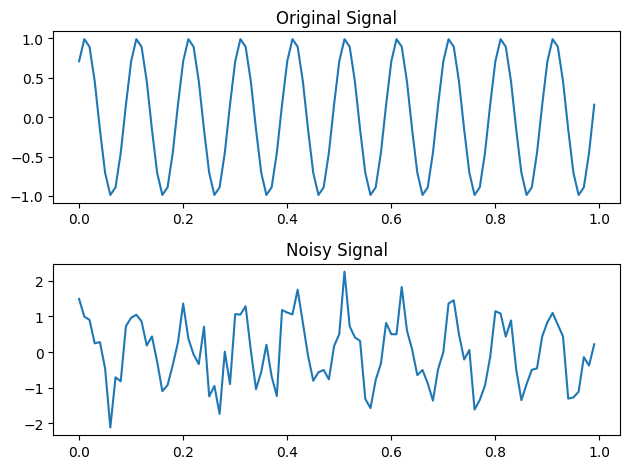

In [9]:
# Sine wave parameters
frequency = 10  # Sine wave frequency in Hz
sample_rate = 100  # Sampling rate in Hz
duration = 1  # Duration in seconds

# Generate time values
t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)

# Create the sine wave
original_signal = np.sin(2 * np.pi * frequency * t + np.pi / 4)

# Generate white noise
noise = np.random.normal(0, 0.5, original_signal.shape)

# Combine the sine wave with noise
noisy_signal = original_signal + noise

# Plot the original and noisy signals
plt.figure()
plt.subplot(2, 1, 1)
plt.plot(t, original_signal)
plt.title('Original Signal')
plt.subplot(2, 1, 2)
plt.plot(t, noisy_signal)
plt.title('Noisy Signal')
plt.tight_layout()
plt.show()

# Question
Estimate phase – Use Hilbert envelope; Fourier approach

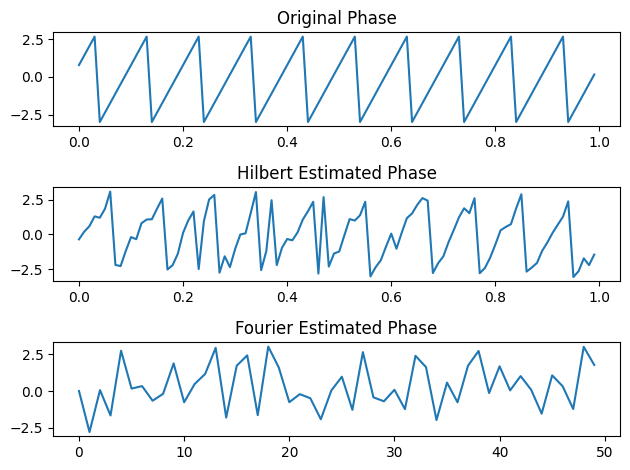

In [10]:
# Hilbert Transform method
analytic_signal = hilbert(noisy_signal)
hilbert_envelope = np.abs(analytic_signal)
hilbert_phase = np.angle(analytic_signal)

# Fourier Transform method
fft_vals = fft(noisy_signal)
fft_freq = fftfreq(int(sample_rate * duration), 1.0/sample_rate)
fft_phase = np.angle(fft_vals)

# Plotting the original phase, Fourier estimated phase, and Hilbert estimated phase
plt.figure()
plt.subplot(3, 1, 1)
plt.plot(t, np.angle(np.exp(1j * (frequency * 2 * np.pi * t + np.pi / 4))))
plt.title('Original Phase')
plt.subplot(3, 1, 2)
plt.plot(t, hilbert_phase)
plt.title('Hilbert Estimated Phase')
plt.subplot(3, 1, 3)
plt.plot(fft_freq[:len(fft_freq)//2], fft_phase[:len(fft_phase)//2])
plt.title('Fourier Estimated Phase')
plt.tight_layout()
plt.show()

**The Hilbert Estimated Phase provides a better estimation than the Fourier estimation, as demonstrated above.**

# Question

Use simulated signals to create frequency-frequency; frequency-phase; phase-phase coupling between two signals

- N:m => 1:2; 1:4; 1:9
- Dependencies – freq, amplitude
- Bonus: Show dependencies with simulation and pen-paper 

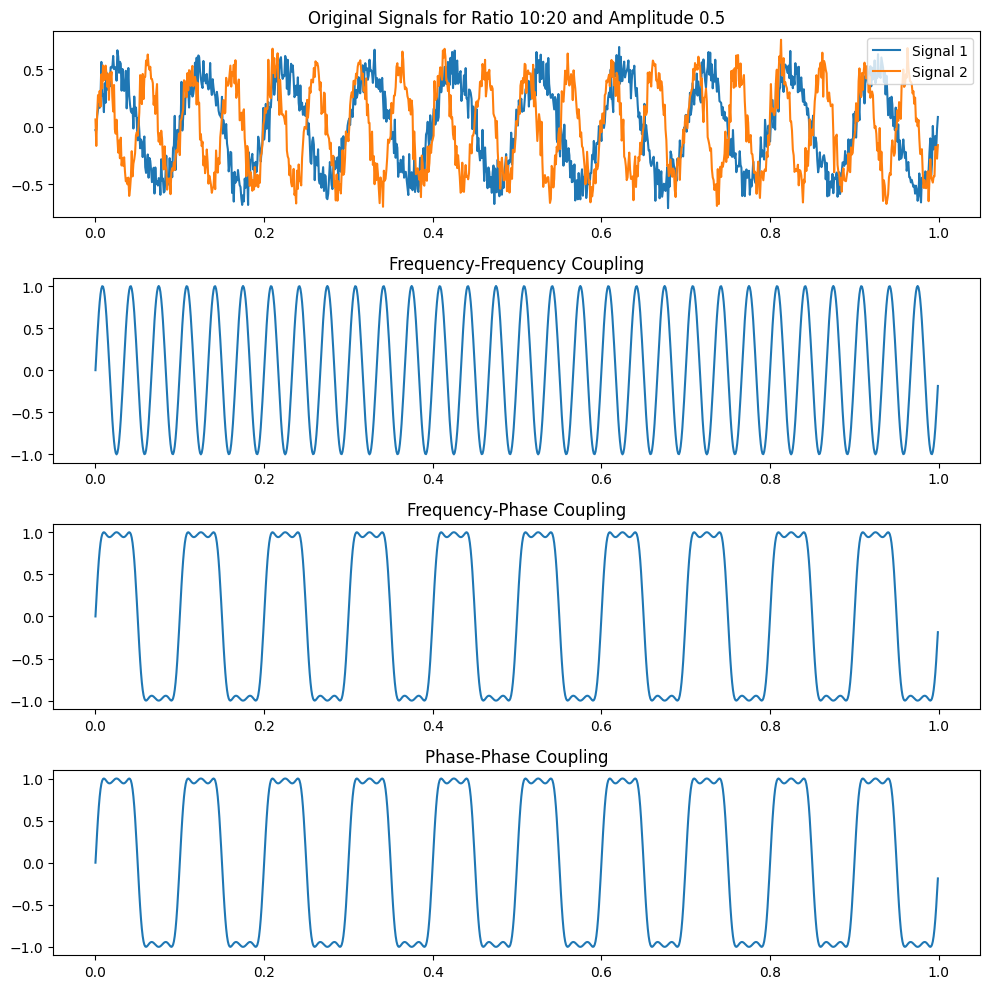

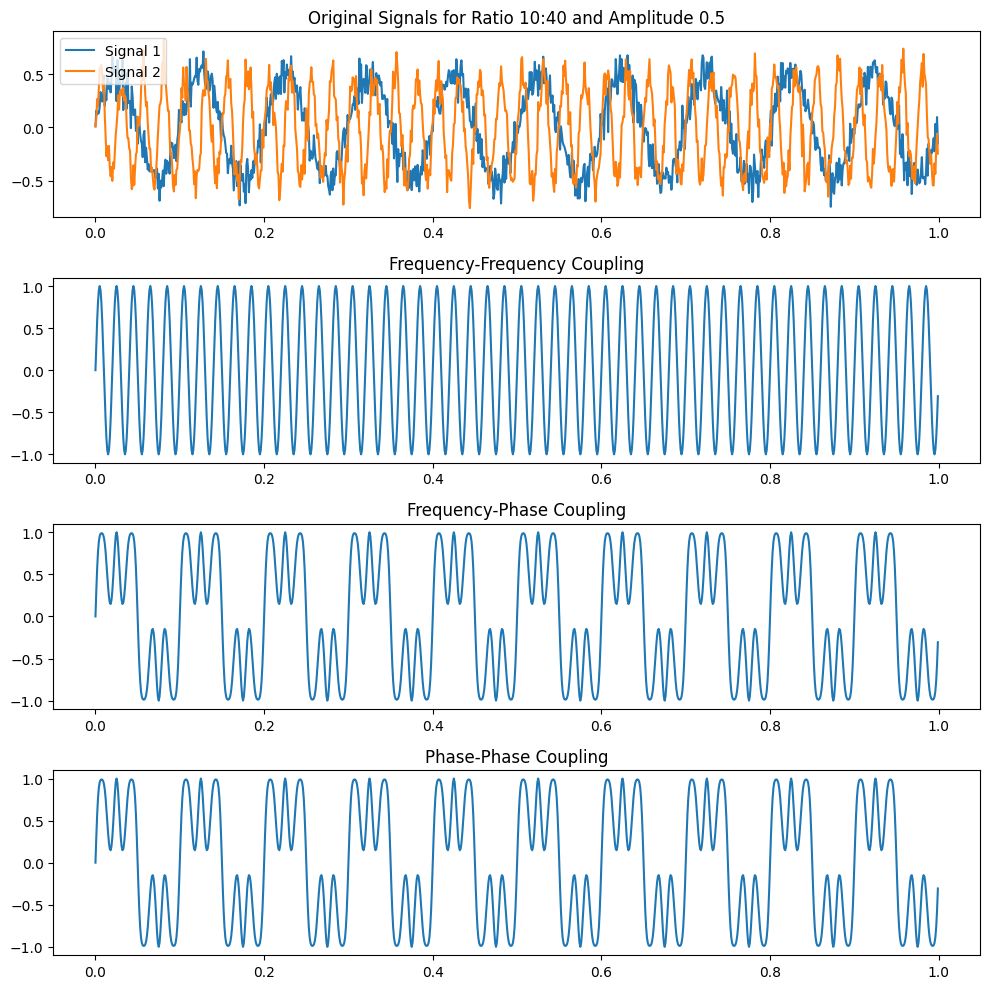

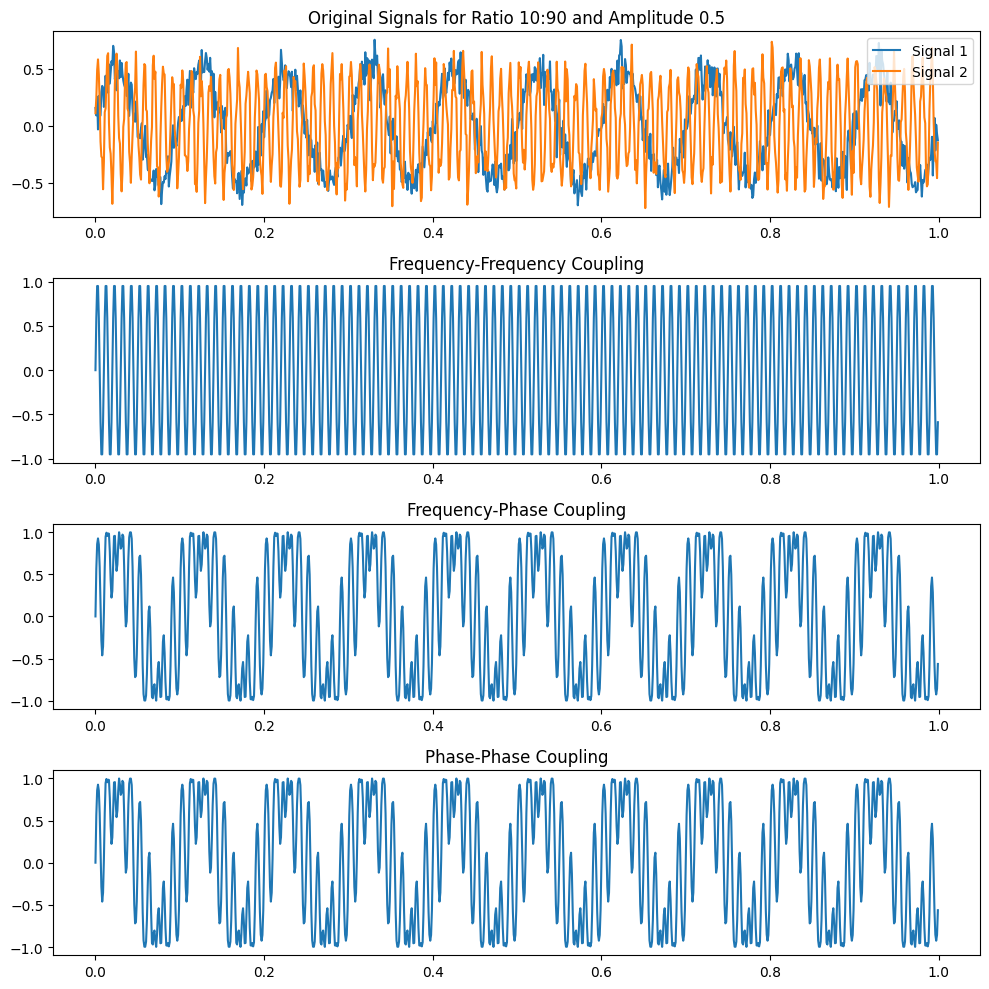

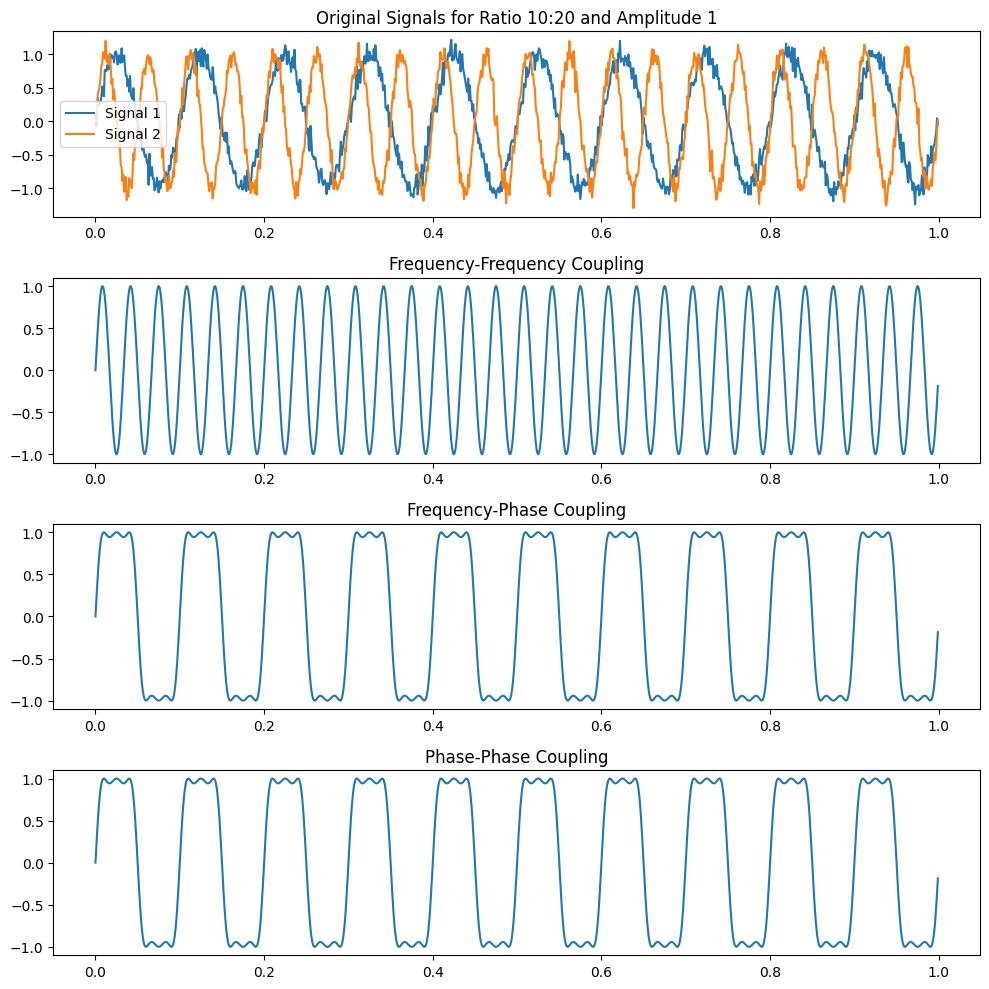

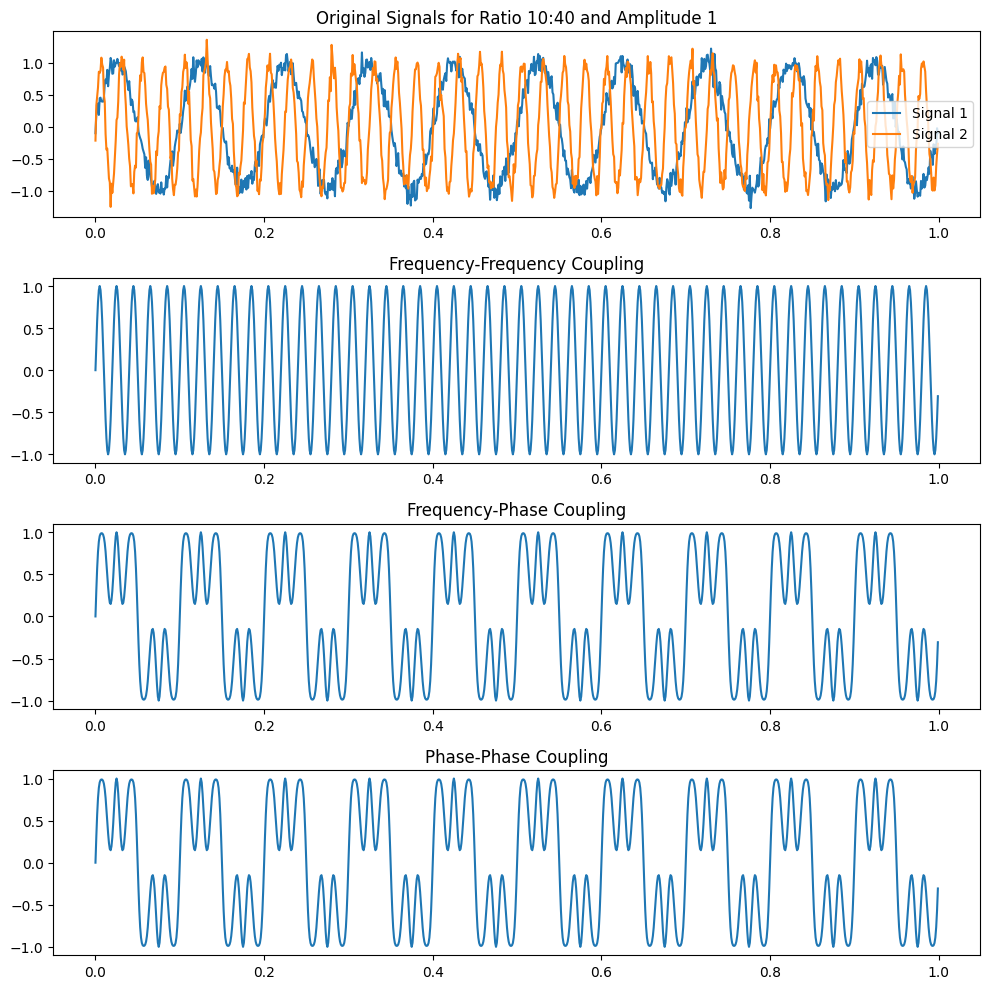

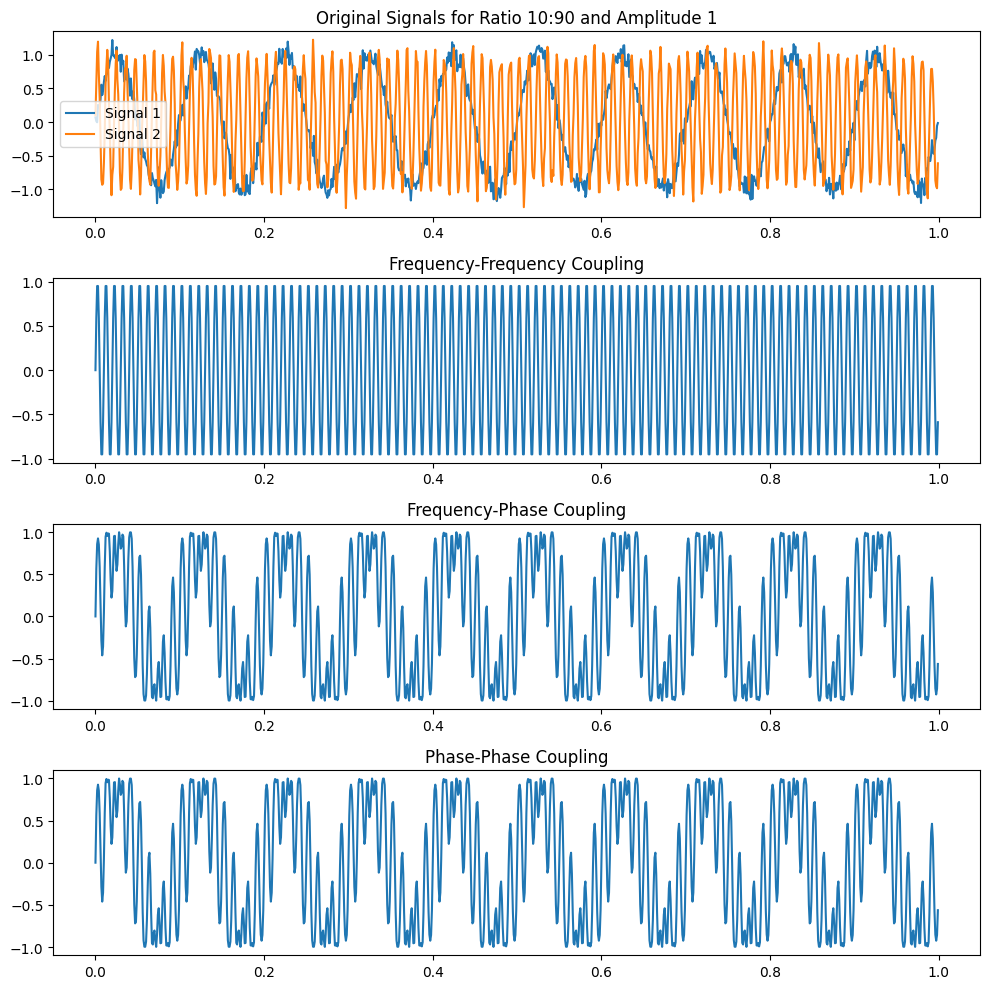

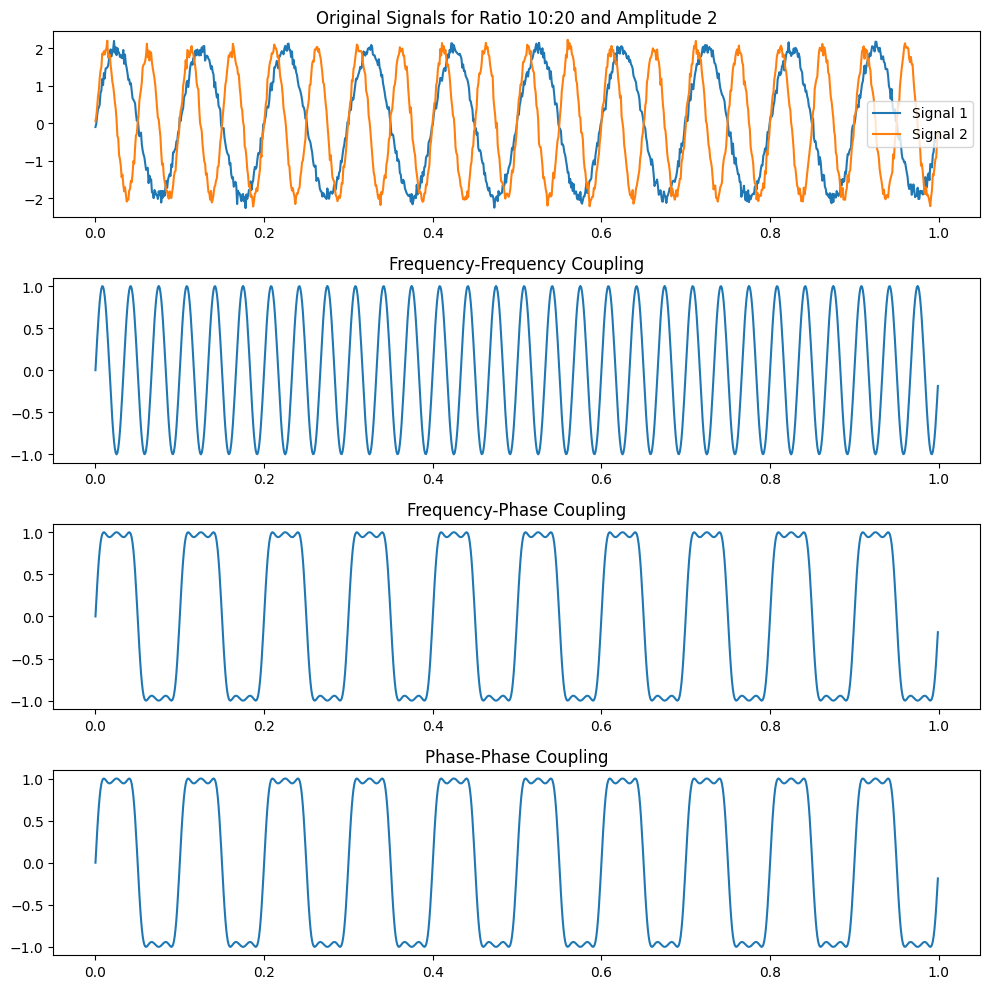

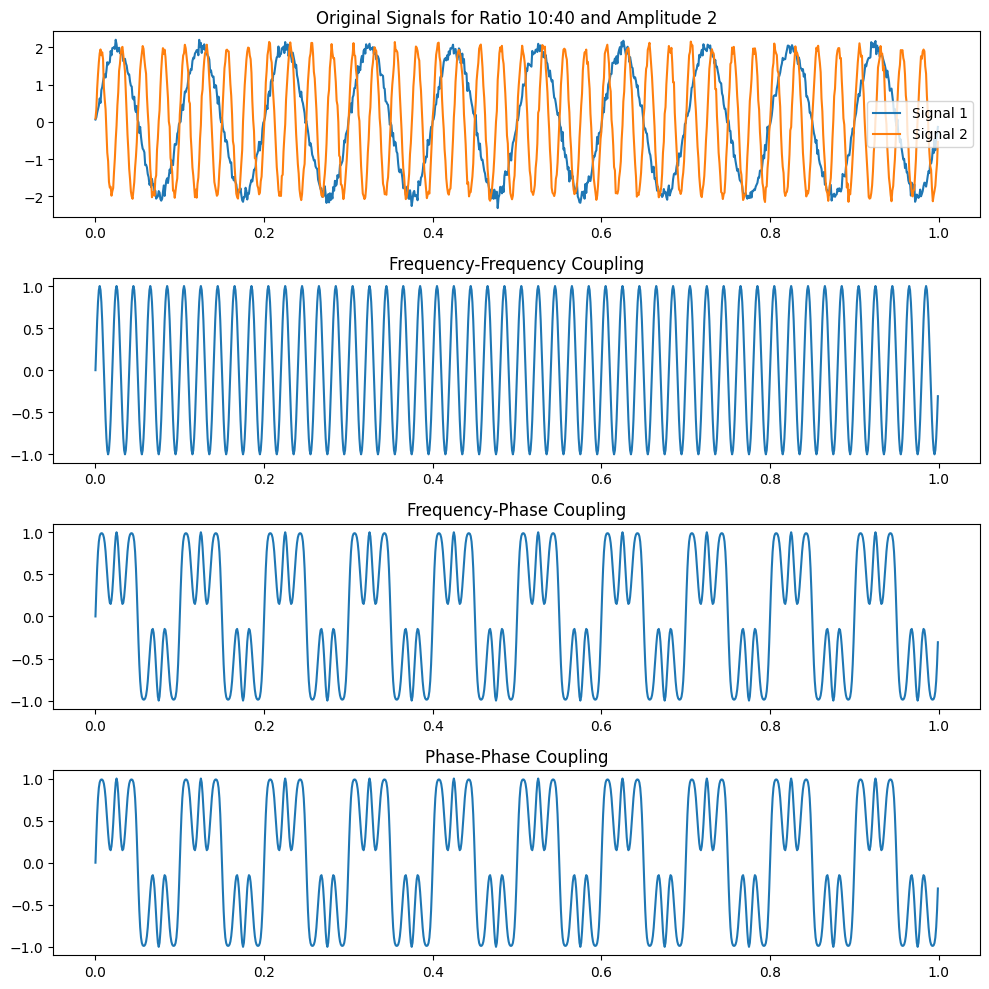

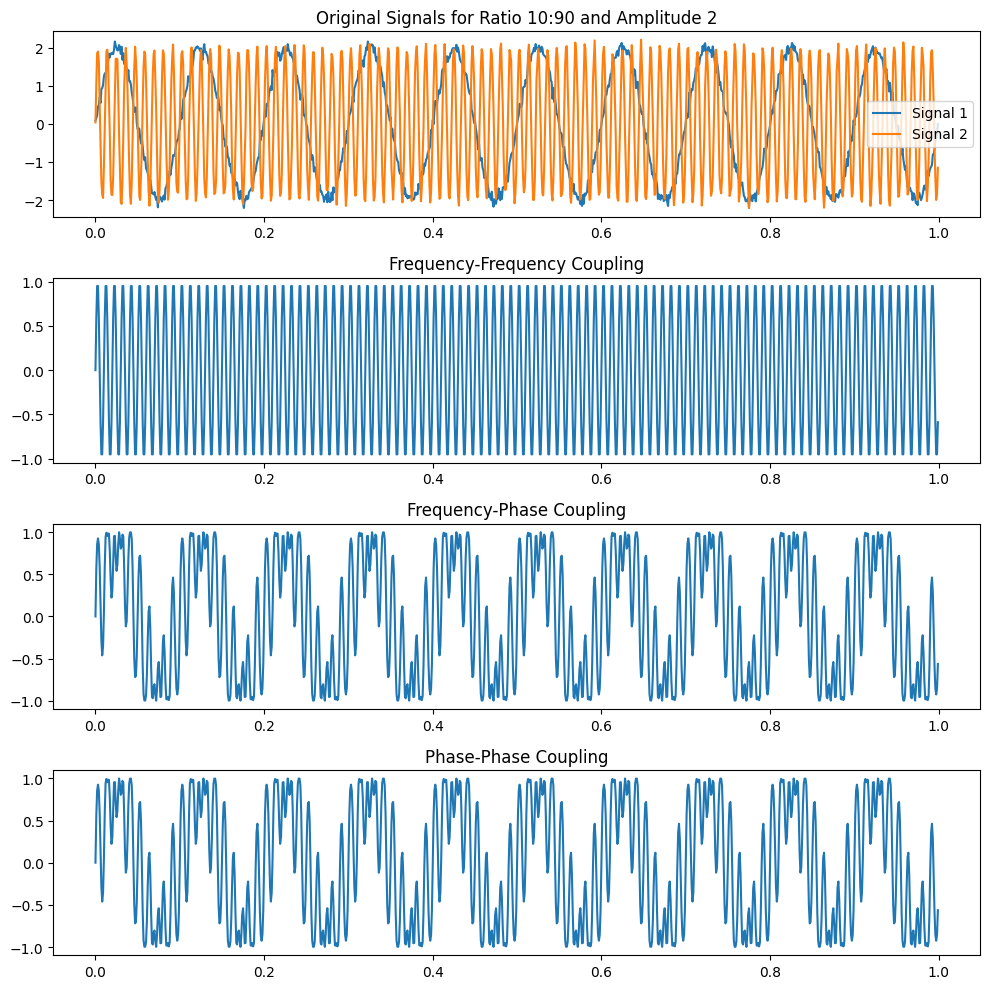

In [11]:
# Parameters for signal generation
sample_rate = 1000  # Sampling rate in Hz
duration = 1  # Duration in seconds
amplitudes = [0.5, 1, 2]
noise_std_dev = 0.1  # Standard deviation of Gaussian noise

# Generate time values
t = np.linspace(0, duration, int(sample_rate * duration), False)

# Frequency ratios for different cases
ratios = [(10, 20), (10, 40), (10, 90)]

for amplitude in amplitudes:
    for ratio in ratios:
        # Generate two signals with specified amplitudes and add Gaussian noise
        signal1 = amplitude * np.sin(ratio[0] * 2 * np.pi * t) + np.random.normal(0, noise_std_dev, len(t))
        signal2 = amplitude * np.sin(ratio[1] * 2 * np.pi * t) + np.random.normal(0, noise_std_dev, len(t))

        # Create frequency-frequency coupling
        ff_coupling = np.sin((ratio[0] + ratio[1]) * 2 * np.pi * t)

        # Create frequency-phase coupling
        fp_coupling = np.sin(ratio[0] * 2 * np.pi * t + np.sin(ratio[1] * 2 * np.pi * t))

        # Create phase-phase coupling
        pp_coupling = np.sin(ratio[0] * 2 * np.pi * t + np.sin(ratio[1] * 2 * np.pi * t))

        # Plot the original signals and the coupled signals
        plt.figure(figsize=(10, 10))
        plt.subplot(4, 1, 1)
        plt.plot(t, signal1, label='Signal 1')
        plt.plot(t, signal2, label='Signal 2')
        plt.title(f'Original Signals for Ratio {ratio[0]}:{ratio[1]} and Amplitude {amplitude}')
        plt.legend()
        plt.subplot(4, 1, 2)
        plt.plot(t, ff_coupling)
        plt.title('Frequency-Frequency Coupling')
        plt.subplot(4, 1, 3)
        plt.plot(t, fp_coupling)
        plt.title('Frequency-Phase Coupling')
        plt.subplot(4, 1, 4)
        plt.plot(t, pp_coupling)
        plt.title('Phase-Phase Coupling')
        plt.tight_layout()
        plt.show()

# Question: We saw STN-M1 have pathological exaggerated synchrony in PD in the beta band (12-30Hz)

## Subpart 1

- Use the Van der Pol oscillator system, modulate the coupling strength to influence
synchrony between STN-M1 & Model the healthy and PD states

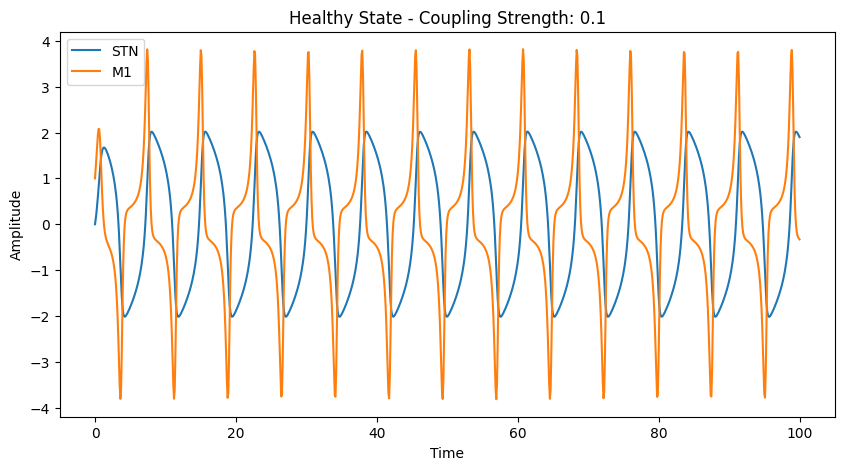

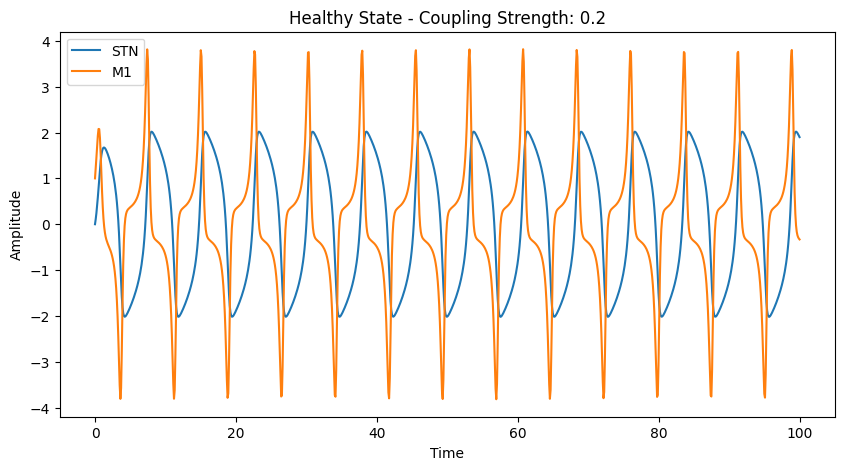

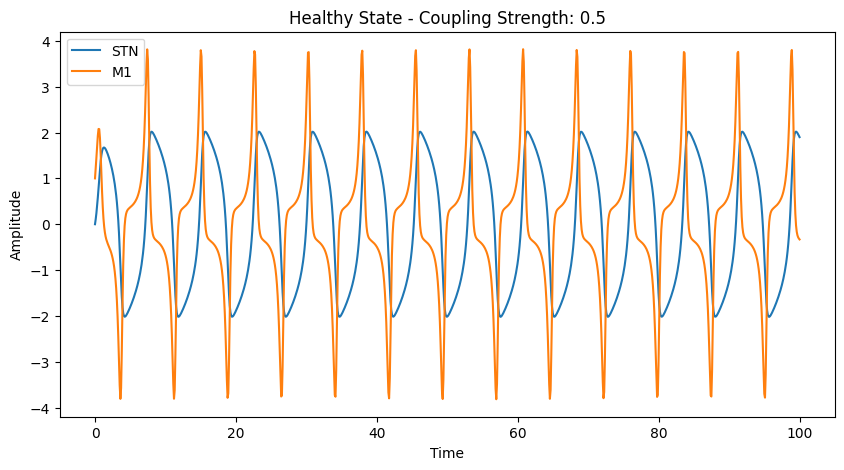

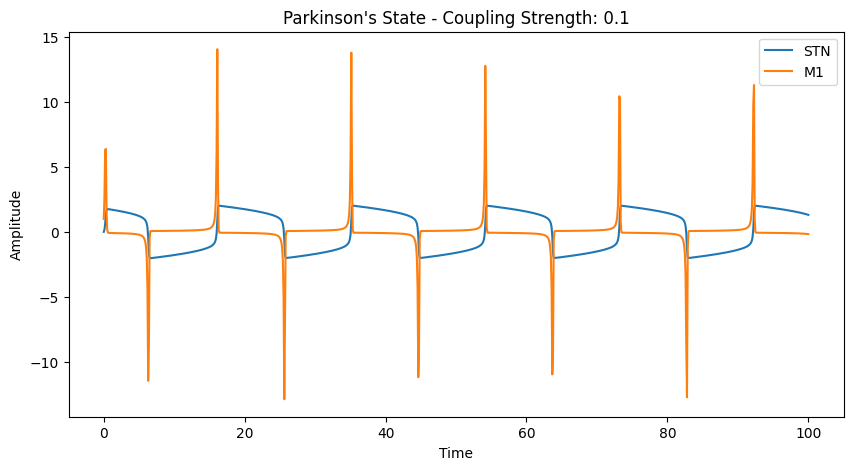

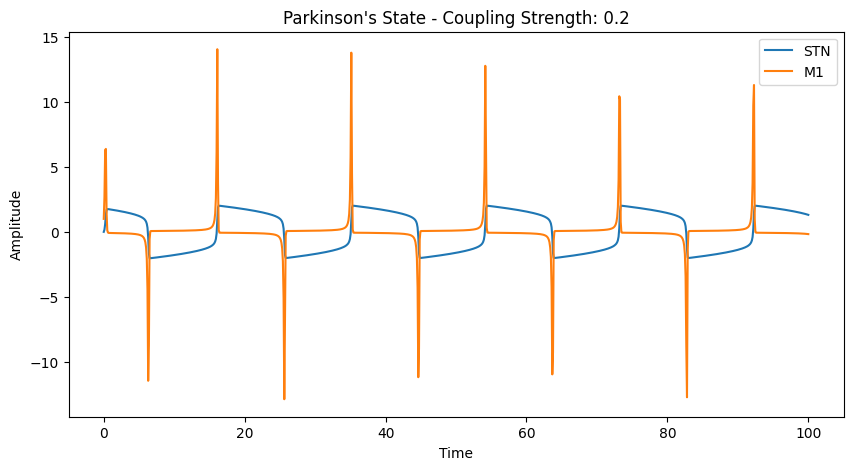

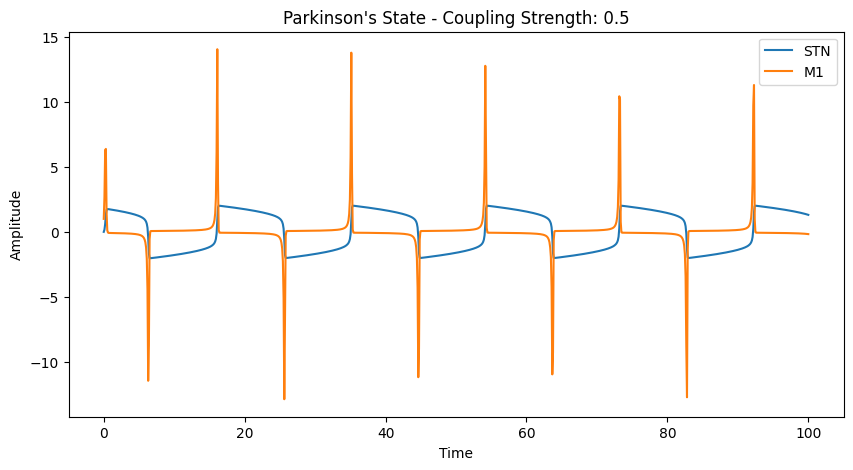

In [12]:
# Van der Pol oscillator equations
def van_der_pol(state_vars, epsilon, beta):
    x, y = state_vars
    dxdt = y
    dydt = epsilon * (beta * (1 - x**2) * y - x)
    return [dxdt, dydt]

# Function to simulate the system
def simulate_system(epsilon, beta, coupling_strength, condition='healthy'):
    # Initial conditions
    initial_conditions = [0.0, 1.0]

    # Time span
    time_span = (0, 100)
    time_eval = np.linspace(time_span[0], time_span[1], 1000)

    # Adjust coupling strength based on the condition
    if condition == 'healthy':
        coupling_modulation = 1.0
    elif condition == 'parkinsons':
        coupling_modulation = 5.0  # Increase coupling strength in Parkinson's

    # Define the coupled system
    def coupled_system(t, state_vars):
        omega = 2 * np.pi * 20  # Frequency in the beta band (12-30Hz)
        return van_der_pol(state_vars, epsilon, beta * coupling_modulation)

    # Solve the system
    solution = solve_ivp(coupled_system, time_span, initial_conditions, t_eval=time_eval)

    return solution

# Function to plot the solution
def plot_solution(solution, title):
    plt.figure(figsize=(10, 5))
    plt.plot(solution.t, solution.y[0], label='STN')
    plt.plot(solution.t, solution.y[1], label='M1')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.show()

# Simulate and plot the healthy state
epsilon = 1.0  # Oscillator parameter
beta = 2.0  # Oscillator parameter
coupling_strengths = [0.1, 0.2, 0.5]  # Different coupling strengths to be plotted

for coupling_strength in coupling_strengths:
    solution_healthy = simulate_system(epsilon, beta, coupling_strength, condition='healthy')
    plot_solution(solution_healthy, f'Healthy State - Coupling Strength: {coupling_strength}')

# Simulate and plot the Parkinson's state
for coupling_strength in coupling_strengths:
    solution_parkinsons = simulate_system(epsilon, beta, coupling_strength, condition='parkinsons')
    plot_solution(solution_parkinsons, f'Parkinson\'s State - Coupling Strength: {coupling_strength}')


## Subpart 2

- Extend the model to include noise in one of the signals – does it improve or decease
synchrony? Explain the results


Introducing noise to a system can have different effects on synchrony, depending on the characteristics of the noise and the dynamics of the system. In some cases, noise might enhance synchrony (stochastic resonance), while in other cases, it might disrupt or decrease synchrony.

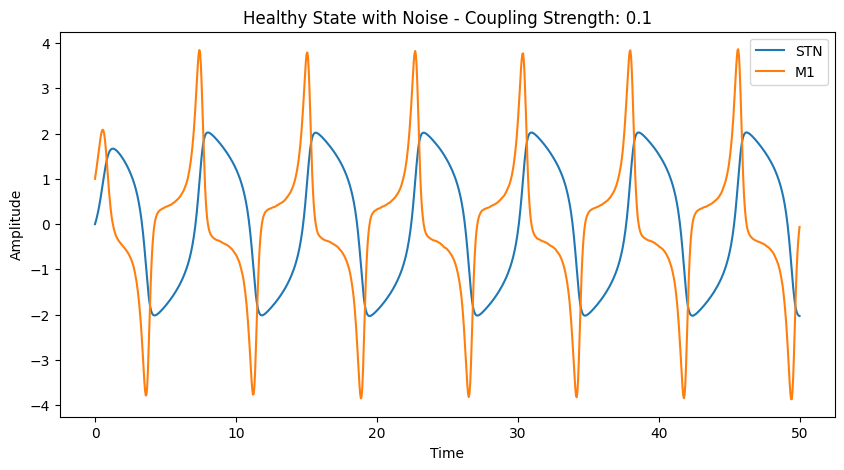

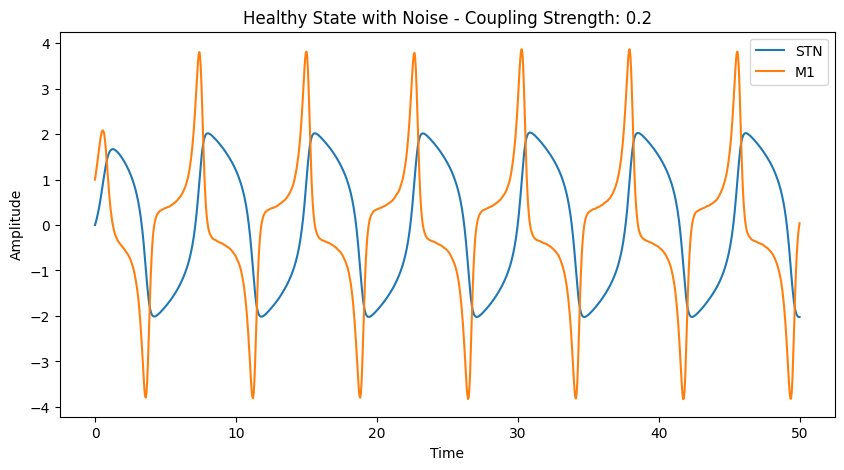

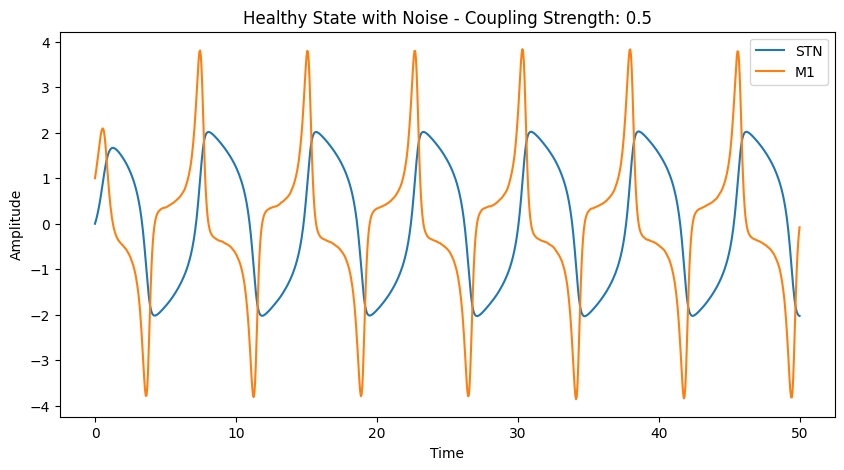

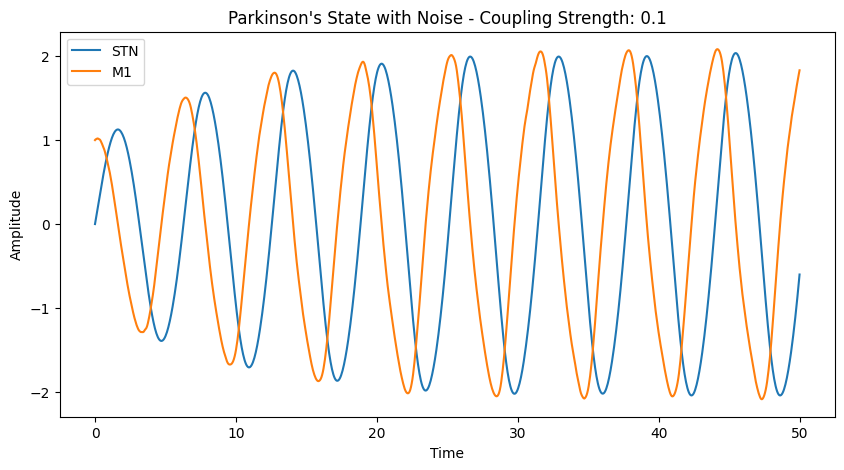

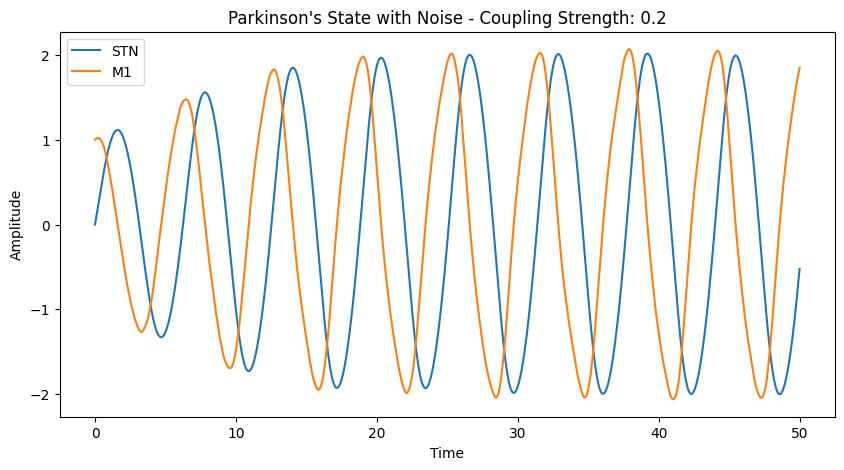

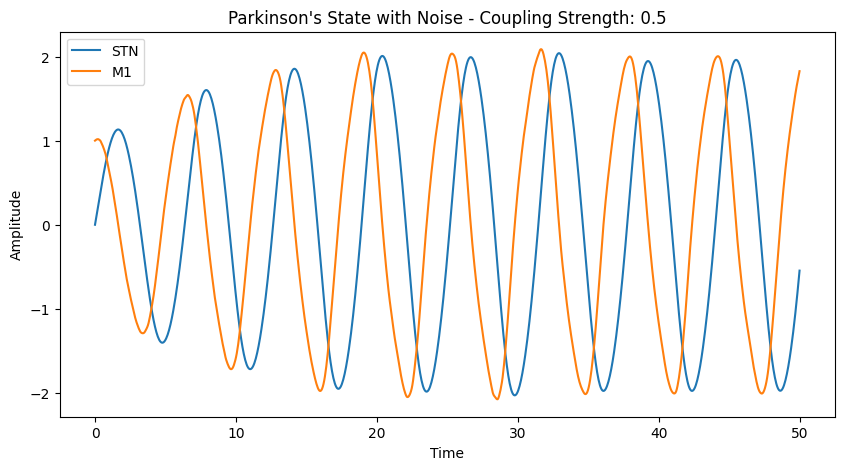

In [13]:
# Van der Pol oscillator equations with noise
def van_der_pol_with_noise(state_vars, epsilon, beta, noise_amplitude):
    x, y = state_vars
    dxdt = y
    dydt = epsilon * (beta * (1 - x**2) * y - x) + noise_amplitude * np.random.normal(0, 0.5)
    return [dxdt, dydt]

# Function to simulate the system with noise
def simulate_system_with_noise(epsilon, beta, coupling_strength, noise_amplitude, condition='healthy'):
    # Initial conditions
    initial_conditions = [0.0, 1.0]

    # Time span
    time_span = (0, 50)
    time_eval = np.linspace(time_span[0], time_span[1], 1000)

    # Define the coupling strength modulation based on the condition
    if condition == 'healthy':
        coupling_modulation = 1.0
    elif condition == 'parkinsons':
        coupling_modulation = 0.1  # Increase coupling strength in Parkinson's

    # Define the coupled system with noise
    def coupled_system_with_noise(t, state_vars):
        omega = 2 * np.pi * 20  # Frequency in the beta band (12-30Hz)
        return van_der_pol_with_noise(state_vars, epsilon, beta * coupling_modulation, noise_amplitude)

    # Solve the system
    solution = solve_ivp(coupled_system_with_noise, time_span, initial_conditions, t_eval=time_eval)

    return solution

# Plotting function
def plot_solution_with_noise(solution, title):
    plt.figure(figsize=(10, 5))
    plt.plot(solution.t, solution.y[0], label='STN')
    plt.plot(solution.t, solution.y[1], label='M1')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.show()

# Simulate and plot the healthy state with noise
noise_amplitude = 0.1  # Adjust the noise amplitude as needed
for coupling_strength in coupling_strengths:
    solution_healthy_with_noise = simulate_system_with_noise(epsilon, beta, coupling_strength, noise_amplitude, condition='healthy')
    plot_solution_with_noise(solution_healthy_with_noise, f'Healthy State with Noise - Coupling Strength: {coupling_strength}')

# Simulate and plot the Parkinson's state with noise
for coupling_strength in coupling_strengths:
    solution_parkinsons_with_noise = simulate_system_with_noise(epsilon, beta, coupling_strength, noise_amplitude, condition='parkinsons')
    plot_solution_with_noise(solution_parkinsons_with_noise, f'Parkinson\'s State with Noise - Coupling Strength: {coupling_strength}')



## Subpart 3
- Can the same model explain the CMC results shown in the lecture?

The Van der Pol oscillator is a simplified model of oscillatory dynamics and does not fully capture the complexities of cortical-muscle communication. Cortical-muscle interactions involve intricate neural networks, biomechanical factors, and sensory feedback, requiring more advanced models. These models consider neural control dynamics, biomechanics, and sensory feedback to accurately represent the complexities of motor behavior and communication between the cortex and muscles.

# Attention – salience – Alpha-gamma coupling. 

- Use the Van der Pol oscillator to show alpha (6-12 Hz) and gamma (>40 Hz) synchrony
- Explore what states typically lead to improved synchronization

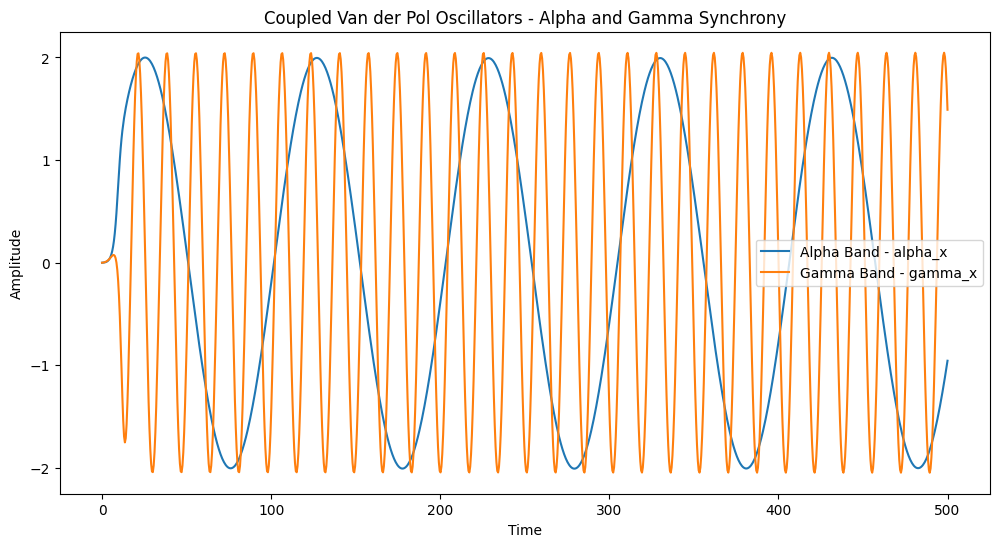

In [14]:
# Parameters
damping_factor = 1.0
alpha_frequency = 2.0 * np.pi * 10.0  # Frequency for the "alpha" band (10 Hz)
gamma_frequency = 2.0 * np.pi * 40.0  # Frequency for the "gamma" band (40 Hz)
forcing_amplitude = 0.1  # Amplitude of the external forcing
forcing_frequency = 2.0 * np.pi * 6.0  # Frequency of the external forcing (6 Hz)

# Function for the coupled Van der Pol oscillators
def coupled_vdp(t, state_vars, damping_factor, alpha_frequency, forcing_amplitude, forcing_frequency, gamma_frequency):
    alpha_x, alpha_y, gamma_x, gamma_y = state_vars

    d_alpha_x_dt = alpha_y
    d_alpha_y_dt = damping_factor * (1 - alpha_x**2) * alpha_y - alpha_frequency**2 * alpha_x + forcing_amplitude * np.sin(forcing_frequency * t) + 0.1 * np.sin(gamma_frequency * t) * gamma_y

    d_gamma_x_dt = gamma_y
    d_gamma_y_dt = damping_factor * (1 - gamma_x**2) * gamma_y - gamma_frequency**2 * gamma_x + forcing_amplitude * np.sin(forcing_frequency * t) + 0.1 * np.sin(alpha_frequency * t) * alpha_y

    return [d_alpha_x_dt, d_alpha_y_dt, d_gamma_x_dt, d_gamma_y_dt]

# Function to simulate the system
def simulate_coupled_system(damping_factor, alpha_frequency, forcing_amplitude, forcing_frequency, gamma_frequency):
    # Initial conditions
    initial_conditions = [0.0, 1.0, 0.0, 1.0]

    # Time span
    time_span = (0, 500)
    time_eval = np.linspace(time_span[0], time_span[1], 1000)

    # Solve the system
    solution = solve_ivp(coupled_vdp, time_span, initial_conditions, args=(damping_factor, alpha_frequency, forcing_amplitude, forcing_frequency, gamma_frequency), t_eval=time_eval)

    return solution

# Plotting function
def plot_solution_coupled(solution, title):
    plt.figure(figsize=(12, 6))
    plt.plot(solution.t, solution.y[0], label='Alpha Band - alpha_x')
    plt.plot(solution.t, solution.y[2], label='Gamma Band - gamma_x')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.show()

# Simulate and plot the coupled system
solution_coupled = simulate_coupled_system(damping_factor, alpha_frequency, forcing_amplitude, forcing_frequency, gamma_frequency)
plot_solution_coupled(solution_coupled, 'Coupled Van der Pol Oscillators - Alpha and Gamma Synchrony')

Synchronization in oscillators can be influenced by various factors. Here are some key factors that improve synchronization:

- **Strong Coupling**: Increasing the coupling strength between oscillators enhances synchronization.
- **Similar Intrinsic Frequencies**: Oscillators with close natural frequencies synchronize more easily.
- **External Forcing**: Introducing rhythmic external forces can help synchronize oscillators.
- **Low Noise**: Lower noise levels facilitate synchronization by maintaining regular oscillatory behavior.
- **Periodic Forcing**: Rhythmic inputs can entrain oscillators to a common frequency.
- **Homogeneous Network**: Similar connectivity among oscillators in a network improves synchronization.
- **Proper Phase Relationships**: Starting with conducive initial phase relationships enhances synchronization.